<a href="https://colab.research.google.com/github/abhiraman/Capstone_Project/blob/main/Image_to_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Dependencies

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import os
import matplotlib.pyplot as plt
import random
import numpy as np
from matplotlib import font_manager
import time
from  torch.utils.data import Dataset,DataLoader 
import pandas as pd
from torchvision import transforms
from skimage import io
from tqdm import tqdm
from collections import OrderedDict
from IPython.display import clear_output

Mounting Drive

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [5]:
%cd /gdrive/MyDrive/Capstone_project_data/ImgtoText/Cropped_Images/cropped_data

/gdrive/MyDrive/Capstone_project_data/ImgtoText/Cropped_Images/cropped_data


In [6]:
!ls

annotations.txt  Img_Text_Recognition.pt    readme.txt
cropped_dir	 model_Text_Recognition.pt


In [7]:
#!unzip 'Sample Train.zip'

In [8]:
if torch.cuda.is_available():
  MyDevice = torch.device("cuda")
else:
  MyDevice = torch.device("cpu")

print(MyDevice)

cpu


# Data Loader 

In [14]:
## All Hindi Alphabets ## 
blank = '-'
all_hindi_alpha = [blank]+[chr(i) for i in range(2304,2432)]
all_hindi_alpha = {all_hindi_alpha[i]:i for i in range(len(all_hindi_alpha))}
print(all_hindi_alpha)
print(len(all_hindi_alpha))

{'-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 110,

In [15]:

with open("annotations.txt") as fh:
  allLineList = fh.readlines()
fh.close()
labelGenerator = (allLineList[i].split('\t')[1].strip('\n') for i in range(0,len(allLineList)-1))
labelGenerator = list(labelGenerator)

In [16]:
print(labelGenerator)
print(max([len(e) for e in labelGenerator]))

['जल', 'शोध', 'न', 'संयंत्र', 'बिना', 'आज्ञा', 'प्रवेश', 'निषेध', 'नगर', 'पालिका', 'परिषद', 'इटारसी', 'जिला', 'होशंगाबाद', 'मप्र', 'स्वच्छ', 'भारत', 'स्वच्छ', 'भारत', 'अभियान', 'स्वच्छता', 'का', 'ध्यान', 'रखें', 'गंदगी', 'न', 'करें', 'शहर', 'को', 'खुले', 'में', 'शौच', 'से', 'मुक्त', 'कराना', 'है', 'शौचालय', 'का', 'उपयोग', 'करें', 'महिला', 'पुरुष', 'मूर्तिकार', 'राजदीप', 'सोनू', 'ॐ', 'ॐ', 'सुनील', 'लांड्री', '९७१३९७६५२०', 'शादी', 'कार्ड', 'संदीप', 'प्रिंटर्स', 'बुक', 'बाइंडिंग', 'मल्टीकलर', 'विजिटिंग', 'कार्ड', 'समस्त', 'छपाई', 'के', 'कार्य', 'सूचना', 'कार्यालय', 'के', 'सामने', 'वाहन', 'खड़ा', 'न', 'करें', 'अन्यथा', 'अर्थदंड', 'रू', 'व', 'न्यायिक', 'कार्यवाही', 'की', 'जावेगी', 'मुख्य', 'कल्याण', 'निरीक्षक', 'इटारसी', 'भारतीय', 'रेल', 'शुभ', 'बैटरी', 'चार्जर', 'रूम', 'राज', 'चाट', 'सेंटर', 'शिव', 'कंप्यूटर', 'सेल्स', 'एण्ड', 'सर्विस', 'शिव', 'पटैल', 'धूम्रपान', 'निषेध', 'रेल', 'परिसर', 'ट्रेन', 'में', 'धूम्रपान', 'तम्बाकू', 'का', 'सेवन', 'करना', 'रेल', 'अधिनियम', 'की', 'धारा', 'व', 'के', 

In [17]:
for eWord in labelGenerator:
  for eStr in eWord:
    print(eStr)
  break

ज
ल


Encode Hindi Words

In [18]:
maxCharLen = 16
def gt_rep(word, letter2index,max_str_len = None, device = 'cpu'):
  gt_rep = torch.zeros([max_str_len, 1], dtype=torch.long).to(device)
  if len(word)<max_str_len:
    diff = max_str_len-len(word)
    word = ''.join((word," "*diff))
  for letter_index, letter in enumerate(word):
    pos = letter2index[letter]
    gt_rep[letter_index][0] = pos
  return gt_rep

def _get_letter_to_index(word,vocabDict):
  finTensor = torch.zeros(len(word)+1,1)
  seqlen = len(word)
  for loopIdx,eChar in enumerate(word):
    idx = vocabDict.get(eChar)
    finTensor[loopIdx] = idx
  finTensor[len(word)] = 2
  return finTensor.permute(1,0),seqlen

In [19]:
class MyCollateClass():
  def __init__(self,dim=1):
    self.dim = dim

  def stackTensors(self,itera):
    return torch.stack(itera['image'])

  def padTensors(self,tensorLabels,maxStrLen):
    finList,sequenceLens = [],[]
    for eTensor in tensorLabels:
      sequenceLens.append(len(eTensor))
      if eTensor.size()[0]<maxStrLen:
        #diff = abs(eTensor.size()[0]-maxStrLen)
        finalTensor = torch.cat([eTensor,torch.ones(1)],dim=0).int()
      else:finalTensor = torch.cat([eTensor,torch.ones(1)],dim=0).int()
      finList.append(finalTensor)
    #finTensor = torch.stack(finList)   
    sequenceLens = torch.Tensor(sequenceLens).int()
    return finList,sequenceLens


  def PadCollate(self,batch):
    
    def _get_max_sentance_len(LabelList):
      return max(list(eTensor.size()[0] for eTensor in LabelList))

    finalDict = {}
    Imglabel_list = list(((eDict['image'],eDict['label']) for eDict in batch))
    ImgTensorList,LabelList = list(zip(*Imglabel_list))
    maxStr_Len = _get_max_sentance_len(LabelList)
    LabelTensor,seqLens = self.padTensors(LabelList,maxStr_Len)
    #finalDict = {"Images":ImgTensor,"Label":LabelTensor,"SeqLength":seqLens}
    return ImgTensorList,LabelTensor,seqLens

  
  def __call__(self,batch):
    return self.PadCollate(batch)


In [20]:
class HindiTextDataset(Dataset):
  def __init__(self,LabelList = None,RootDirectory = None,transform=None,vocabList=None):
    self.LabelList = LabelList
    self.root_dir = RootDirectory
    self.transform = transform
    self.vocabList = vocabList
    self.startIndex = 0
    self.indexes = [i for i in range(len(self.LabelList))]
    random.shuffle(self.indexes)


  def __len__(self):
    return len(self.LabelList)
  
  def _get_letter_to_index(self,idx):
    strList = []
    for eChar in self.LabelList[idx]:
      strList.append(self.vocabList.get(eChar))
      
    return torch.Tensor(strList).int()

  def __getitem__(self,idx):
    img_tensor = io.imread(''.join([self.root_dir,str(idx),'.jpg']))
    img_tensor = self.transform(img_tensor)
    img_tensor = transforms.functional.resize(img_tensor,(128,128))
    label_tensor = self._get_letter_to_index(idx)
    sample = {'image':img_tensor,'label':label_tensor}
    return sample
  
  def _get_batchData(self,batch):
    end = self.startIndex + batch
    imgList,wordList = [],[]
    for ind in  range(end):
      idx = self.indexes[ind]
      word = self.LabelList[idx]
      img_tensor = io.imread(''.join([self.root_dir,str(idx),'.jpg']))
      # print(img_tensor.shape)
      # print(img_tensor.shape)
      # fig = plt.figure()
      # ax = fig.subplots(1,1)
      # ax.imshow(img_tensor)
      img_tensor = self.transform(img_tensor)
      img_tensor = transforms.functional.resize(img_tensor,(128,128)) ## (Number of channels*Height*Width)
      # print(img_tensor.shape)
      # fig = plt.figure()
      # ax = fig.subplots(1,1)
      # ax.imshow(img_tensor)
      imgList.append(img_tensor)
      wordList.append(word)
    return imgList,wordList




In [21]:
transform_batch = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# transform_batch = transforms.Compose([
#      transforms.ToTensor()])  

In [22]:
TextDataset = HindiTextDataset(labelGenerator,"cropped_dir/",transform = transform_batch,vocabList=all_hindi_alpha)


In [23]:
imgTensor,wordList = TextDataset._get_batchData(5)
for i in wordList:
  rep = _get_letter_to_index(i,all_hindi_alpha)
  print(rep)

(tensor([[43., 78., 49., 63., 27., 65.,  2.]]), 6)
(tensor([[22.,  3., 29.,  2.]]), 3)
(tensor([[58., 73.,  2.]]), 2)
(tensor([[48., 58., 65.,  2.]]), 3)
(tensor([[46., 24., 54., 63., 41.,  2.]]), 5)


Custom Dataset Loader 

In [24]:
batch_size = 5
dataloader1 = DataLoader(TextDataset, batch_size=batch_size,
                        shuffle=True, num_workers=0,collate_fn=MyCollateClass())

In [25]:
for i,data in enumerate(dataloader1):
  print('i;',i)
  print(len(data[0]),len(data[1]),len(data[2]))
  if i>3:
    break

i; 0
5 5 5
i; 1
5 5 5
i; 2
5 5 5
i; 3
5 5 5
i; 4
5 5 5


Show Sample Data

TypeError: ignored

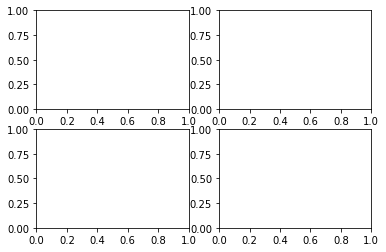

In [26]:
for ind,data in enumerate(dataloader1):
  if ind>0:break
  fig = plt.figure()
  nrows,ncols = batch_size//2,batch_size//2
  ax = fig.subplots(nrows,ncols)
  counter = 0
  for i in range(nrows):
    for j in range(ncols):
      ax[i,j].imshow(data['Images'][counter][0][0:60][0:100])
      counter+=1



# ENCODER PART

In [27]:
class RCNN(nn.Module):
  def __init__(self,imgChannel,imgHeight,imgWidth,output_size,mapHidden=64,rnn_hidden =256,leaky_relu=False,verbose=False):
    super().__init__()
    self.verbose = verbose
    self.encoder,(n_channels,height,width) = self._cnn_backbone(imgChannel,imgHeight,imgWidth,leaky_relu)
    self.map_to_seq = nn.Linear(n_channels*height,mapHidden) ## mapHidden > len(hindivocab)
    self.rnn1 = nn.LSTM(mapHidden,rnn_hidden)
    self.dense = nn.Linear(rnn_hidden,output_size)
    self.softMAX = nn.Softmax(dim = 2)
    self.verbose = verbose
    
  def _cnn_backbone(self,img_channel,img_height,img_width,leaky_relu):
    self.encoder = nn.Sequential()
    assert img_height % 16 == 0
    assert img_width % 4 == 0

    channels = [img_channel, 64, 128, 256, 256, 512, 512, 512]
    kernel_sizes = [3, 3, 3, 3, 3, 3, 2]
    strides = [1, 1, 1, 1, 1, 1, 1]
    paddings = [1, 1, 1, 1, 1, 1, 0]

    cnn = nn.Sequential()
    def conv_relu(i, batch_norm=False):
      # shape of input: (batch, input_channel, height, width)
      input_channel = channels[i]
      output_channel = channels[i+1]

      cnn.add_module(
          f'conv{i}',
          nn.Conv2d(input_channel, output_channel, kernel_sizes[i], strides[i], paddings[i])
      )

      if batch_norm:
          cnn.add_module(f'batchnorm{i}', nn.BatchNorm2d(output_channel))

      relu = nn.LeakyReLU(0.2, inplace=True) if leaky_relu else nn.ReLU(inplace=True)
      cnn.add_module(f'relu{i}', relu)
    
    conv_relu(0)
    cnn.add_module('pooling0', nn.MaxPool2d(kernel_size=2, stride=2))
    # (64, img_height // 2, img_width // 2)

    conv_relu(1)
    cnn.add_module('pooling1', nn.MaxPool2d(kernel_size=2, stride=2))
    # (128, img_height // 4, img_width // 4)

    conv_relu(2)
    conv_relu(3)
    cnn.add_module(
        'pooling2',
        nn.MaxPool2d(kernel_size=(2, 1))
    )  # (256, img_height // 8, img_width // 4)

    conv_relu(4, batch_norm=True)
    conv_relu(5, batch_norm=True)
    cnn.add_module(
        'pooling3',
        nn.MaxPool2d(kernel_size=(2, 1))
    )  # (512, img_height // 16, img_width // 4)

    conv_relu(6)  # (512, img_height // 16 - 1, img_width // 4 - 1)

    output_channel, output_height,output_width = \
        channels[-1], img_height // 16 - 1, img_width // 4 - 1
    return cnn, (output_channel, output_height,output_width)

  def forward(self,x,train=True):
    conv = self.encoder(x)
    if self.verbose:
      print("Input Shape : ",x.size())
      print("Encoder Output : ",conv.size())

    batch, channel, height, width = conv.size()
    conv = conv.view(batch, channel * height, width)
    conv = conv.permute(2, 0, 1)  # (width, batch, feature)
    seq = self.map_to_seq(conv)
    recurrent, _ = self.rnn1(seq)
    output = self.dense(recurrent)
    if not train:
      output = self.softMAX(output)
    if self.verbose:
      print("Input to Decoder : ",seq.size())
      print("RNN Output : ",recurrent.size())
      print("Decoder Ouptput : ",output.size())

    return output

Encoder Check

In [ ]:
obj = RCNN(3,128,128,len(all_hindi_alpha),verbose=True)
imgTensor = TextDataset._get_batchData(1)
dd = obj(imgTensor[0][0].unsqueeze(0))
print(dd.size())
0/0

# DECODER PART

In [ ]:
## Extracted feature from CNN will act as input for Encoder-Decoder Model , each column x channel Depth on an input for the encoder-decoder model ## 
class LSTM_Net(nn.Module):
  def __init__(self,input_size=None,batch_size=None,hidden_size=None,output_size=None,numLayers=1,numDirns=1,verbose=False):
    self.hidden_size = hidden_size
    self.batch_size = batch_size
    self.numLayers = numLayers
    self.numDirns = numDirns

    super().__init__()
    self.hidden_size = hidden_size
    self.lstm_cell = nn.LSTM(input_size,hidden_size,num_layers=self.numLayers,batch_first=True,bidirectional =True)
    self.h2o = nn.Linear(self.numDirns*hidden_size,output_size)
    self.F = nn.ReLU()
    self.SoftMAX = nn.Softmax(dim=2)

    self.verbose = verbose
   

  def forward(self,input,hidden,training=True):
    out,hidden = self.lstm_cell(input,hidden)
    output = self.F(self.h2o(out))
    outputt = self.SoftMAX(output)
    
    if self.verbose:
      print("Input to decoder : ",input.size())
      print("LSTM Output of all time steps : ",out.size())
      print("FC Output : ",output.size())
    return outputt
  
  def init_hiddenlayer(self,device='cpu'):
    return (torch.zeros(self.numLayers*self.numDirns,1,self.hidden_size).to(device),torch.zeros(self.numLayers*self.numDirns,1,self.hidden_size).to(device))


# Inference & Accuracy

In [28]:
def _computeAccuracy(source,target,device='cpu'):
  def _convertTarget_toList(target):
    target = target.squeeze(0).int().tolist()
    return target


  def _return_collapsedIndexes(idxList):
    idxList = idxList.squeeze(1).int().tolist()
    cleanedList = []

    for ind,wordInd in enumerate(idxList):
      if ind==0:
        cleanedList.append(wordInd)
        continue
      if cleanedList[-1] ==wordInd:continue
      else:cleanedList.append(wordInd)
    print("cleanedList:",cleanedList)
    return cleanedList
  
  def _convertIndex_toString(indexx,VocabList):
    k,v = list(VocabList.keys()),list(VocabList.values())
    ss = ''
    for i in indexx:
      if i == 0:
        ss+="<blank>"
        continue
      ss+=k[v.index(i)]
    return ss
        
  def _convertSource_toList(source):
    source = source.detach()
    
    source_idx = torch.argmax(source,dim=2)
    print("source_idx : ",source_idx)
    collapsedIndexs = _return_collapsedIndexes(source_idx)
    return collapsedIndexs

  

  targetList = _convertTarget_toList(target)
  sourceList = _convertSource_toList(source)


  targetWord = _convertIndex_toString(targetList,all_hindi_alpha)
  predWord = _convertIndex_toString(sourceList,all_hindi_alpha)



  # score =0
  # partialScore = 0
  # for eSource,eTarget in zip(sourceList,targetList):
  #   if eSource ==[]:continue
  #   if set(eSource).issubset(eTarget) and len(eSource)==len(eTarget):score+=1
  #   elif set(eSource).issubset(eTarget):partialScore+=1
  
  return predWord,targetWord
  
  

# Core Trainer




In [29]:
def coreTrainer(batchSize,net,lossFn =None,device='cpu',train=True):
  TextDataset = HindiTextDataset(labelGenerator,"cropped_dir/",transform = transform_batch,vocabList=all_hindi_alpha)
  img_tensorList,hindiWords =  TextDataset._get_batchData(batchSize)
  counter=0
  cummLoss=0
  for img_tensor,hindiWord in zip(img_tensorList,hindiWords):
    targets,seqLen = _get_letter_to_index(hindiWord,all_hindi_alpha)
    img_tensor,targets,seqLen = img_tensor.to(device),targets.to(device),seqLen
    decoder_fpass = net(img_tensor.unsqueeze(0),train)
    if not train:
      return decoder_fpass,targets
      
    log_probs = torch.nn.functional.log_softmax(decoder_fpass, dim=2)
    input_lengths = torch.Tensor([decoder_fpass.size()[0]] * 1).int().to(device)
    target_lengths = torch.Tensor([seqLen] * 1 ).int().to(device)
    loss =  lossFn(log_probs,targets,input_lengths,target_lengths)/batchSize
    loss.backward()
    cummLoss+=loss
  

  return cummLoss/batchSize


In [30]:
def batchTrain(net,lossFn=None,optimFn=None,scheduler=None,batchSize=None,epochs=1,display_feq=10,device='cpu'):
  minVal= 1000000 
  net.to(device)
  ## Intialize both the models ##
  loss_per_epoch_array = torch.zeros(epochs+1)
  for i in range(epochs):
    
    optimFn.zero_grad()
    loss_per_epoch_array[i+1] = (loss_per_epoch_array[i]*i + coreTrainer(batchSize,net,lossFn,device,train=True))/(i+1)
    optimFn.step()

    
    #scheduler.step(loss)
    if loss_per_epoch_array[i]<minVal and i>0:
      minVal = loss_per_epoch_array[i]
      torch.save({
          'model_dict': net.state_dict(),
          }, "Img_Text_Recognition.pt")
    
    if i%display_feq == 0 and i!=0: 
      clear_output(wait=True)
      print("For Epoch {} ----> Loss {}".format(i,loss_per_epoch_array[i]))
      plt.figure()
      plt.plot(loss_per_epoch_array[1:i].detach().numpy(),'-*')
      plt.xlabel("Epochs")
      plt.ylabel("Epoch Loss")
      plt.show()  

      net.eval()
      decoder_fpass,targets = coreTrainer(1,net,lossFn =None,device=device,train=False)
      predWord,actWord = _computeAccuracy(decoder_fpass,targets)
      print("predWord --> {} , actWord --> {}".format (predWord,actWord))
      net.train()



# BatchHelper

In [31]:
## HYPERPARAMETERS
batchSize = 1000
num_layers = 1
num_dirn = 2
hidden_size = 200
lr = 0.005

In [32]:
ctc_loss = nn.CTCLoss(blank=0,zero_infinity=True)
# EncoderObj = FeatureExtractor(verbose=False).to(MyDevice)
# DecoderObj = LSTM_Net(input_size=6*512,batch_size=batchSize,hidden_size=hidden_size,output_size=len(all_hindi_alpha),numLayers=num_layers,numDirns=num_dirn,verbose=False).to(MyDevice)
net = RCNN(3,128,128,len(all_hindi_alpha),verbose=False)
optimFn = optim.Adam(net.parameters(),lr=lr)

In [ ]:
batchTrain(net,lossFn=ctc_loss,optimFn=optimFn,batchSize=batchSize,epochs=500,device=MyDevice)                                                                                                               

In [ ]:
checkpoint = torch.load('model_Text_Recognition.pt')
EncoderObj.load_state_dict(checkpoint['encoder_state_dict'])
DecoderObj.load_state_dict(checkpoint['decoder_state_dict'])
optimFn.load_state_dict(checkpoint['optimizer_state_dict'])